In [93]:
import os
import numpy as np # type: ignore
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymultifracs.psd as psd
from pymultifracs.utils import freq2scale, scale2freq
fs = 256
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log
from fracModel import fracOrdUU
from itertools import chain

import warnings
warnings.filterwarnings('ignore')


class CogBeaconDataset:
    def __init__(self, root_path):
        self.root_path = root_path
        self.eeg_path = os.path.join(root_path, 'eeg')
        self.label_path = os.path.join(root_path,'fatigue_self_report')


    def parse_folder_name(self, folder_name): # this is for reading the session folder that contains eeg files
        parts = folder_name.split('_')
        user_id = parts[1]
        stimuli_type = parts[2]
        game_mode = parts[3]
        
        if "b" in user_id:
            session_day = "Second"
            wcst_version = "V2" if game_mode == "m" else "o"
        else:
            session_day = "First"
            wcst_version = "V1" if game_mode == "m" else "o"
        
        return {
            'user_id': user_id,
            'stimuli_type': stimuli_type,
            'game_mode': game_mode,
            'session_day': session_day,
            'wcst_version': wcst_version
        }

    def parse_file_name(self, file_name): # this for each eeg data in easch session
        parts = file_name.split('_')
        round_id_same_rule = parts[0] # the same ids of the i=first part is the when the rounds in the game have the same rule to follow
        round_id = parts[1].split('.')[0] 
        
        return {
            'round_id_same_rule': round_id_same_rule,
            'round_id': round_id
        }
    
    def read_eeg_file(self, file_path):
        eeg_data = []
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    if line.startswith('eeg'):
                        data = list(map(float, line.split()[1:]))
                        eeg_data.append(data)
            # print("the  size of the eeg data if {} is {}".format(file_path,eeg_data))            

            return eeg_data
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return None

    def process_session(self, session_folder):
        session_path = os.path.join(self.eeg_path, session_folder)
        # print("checkpoint A - session Path ", session_path)
        session_info = self.parse_folder_name(session_folder)
        
        eeg_data = []
        
        file_names = os.listdir(session_path)

        def sort_key(file_name): # sorting the filename to make the reading of the data in the order of the expriment time
            match = re.match(r"(\d+)_(\d+)", file_name)
            if match:
                return (int(match.group(1)), int(match.group(2)))  
            return (float('inf'), float('inf')) 
        file_names.sort(key=sort_key)

        for file_name in file_names:
            # print("process session", file_name)
            file_info = self.parse_file_name(file_name)
            file_path = os.path.join(session_path, file_name)
            data = self.read_eeg_file(file_path)
            eeg_data.append(data) 
        # print("there are {} eeg recoding in the session {}".format(len(eeg_data), file_name))   
        return eeg_data
                # eeg_data.append({
                #     'file_info': file_info,
                #     'data': data
                # })
        
        # return {
        #     'session_info': session_info,
        #     'eeg_data': eeg_data
        # }
        # return eeg_data

    def load_all_sessions(self):
        all_sessions = []
        for session_folder in os.listdir(self.eeg_path):
            if os.path.isdir(os.path.join(self.eeg_path, session_folder)):
                task_data = self.process_session(session_folder)
                all_sessions.append(task_data)
        return all_sessions
    
    def load_session_by_participant(self, user_id, session_day,game_mode,channel):
        # target_sessions = []
        for session_folder in os.listdir(self.eeg_path):
            if os.path.isdir(os.path.join(self.eeg_path, session_folder)):
                session_info = self.parse_folder_name(session_folder)
                if session_info['user_id'] == str(user_id) and session_info['session_day'] == session_day and session_info['game_mode']  == game_mode:
                    task_data = self.process_session(session_folder)
                    session_fatiguereport= self.read_fatigue_self_report(session_folder)
                    print("session loaded successfully",session_info,"size of the session data", len(task_data))
        if not task_data:
                print("file not found!!!!",session_info['user_id'] , str(user_id),session_info['session_day'] , session_day)
        if channel:
            task_data = self.separet_channels_per_turn(task_data)[channel]
            # print("checkpoint C, task_data after channel separation:", len(task_data))
            # print(len(task_data),task_data[0])
              


        return task_data , session_fatiguereport
    def read_fatigue_self_report(self,file_path):
        path = os.path.join(self.label_path, file_path+".csv")
        fatigue_reports = pd.read_csv(path)
        fatigue_list = fatigue_reports.values.tolist()
        # print("Checkpoint E, fatigue labels ", len(fatigue_list), fatigue_list)
        return fatigue_list
                       

    def separet_channels_per_turn(self,signal):
        #  "TP9 FP1 FP2 TP10"
        # TP9, FP1,FP2,TP10 = [],[],[],[]
        eeg_per_channel_per_channel = {
            "TP9":[],
            "FP1":[],
            "FP2":[],
            "TP10":[]
        }
        # print(signal)
        for turn in signal:
            TP9, FP1,FP2,TP10 = [],[],[],[]
            for rnd in turn:
                TP9.append(rnd[0])
                FP1.append(rnd[1])
                FP2.append(rnd[2])
                TP10.append(rnd[3])
            eeg_per_channel_per_channel["TP9"].append(TP9)
            eeg_per_channel_per_channel["TP10"].append(TP10)
            eeg_per_channel_per_channel["FP1"].append(FP1)
            eeg_per_channel_per_channel["FP2"].append(FP2)
        
        return eeg_per_channel_per_channel
    

    def flattern_turns(self,task_data,task_label):
        """
        This function puts together the whole task turn in a one temporal sequence (all turn of a task in a 1d signal)

        """
        # def flatten_chain(matrix):
        #     return list(chain.from_iterable(matrix))
        flattened_task_data = []
        extended_labels =[]
        for sublist,label in zip(task_data,task_label):
            flattened_task_data.extend(sublist)
            extended_labels.extend([label] * len(sublist))

        # print(type(flattened_task_data), flattened_task_data)
        return flattened_task_data,extended_labels

 
            
## the address of dataset in your local machine   
cogbeacon_root_path = '/Users/athenasaghi/Desktop/Datasets/CogBeacon-MultiModal_Dataset_for_Cognitive_Fatigue-master/'
dataset = CogBeaconDataset(cogbeacon_root_path)


In [1]:
%load_ext autoreload
%autoreload 2
def mfda_features(X,plot):
    """
    This function performs multifractal analysis on the input signal X
    
    Inputs:
         X - should be a 1d array
        look into pymultifracs library for further detaila and examples on how to use it (https://github.com/neurospin/pymultifracs/tree/master)

    Output : 
        Holder exponent
        D_q
        q (scaling orders)
    """
    dwt, lwt = mfa.mf_analysis_full(X,
    scaling_ranges=[[1,3],[2,4]],
    q = build_q_log(1, 10, 20),
    n_cumul=2,
    p_exp=np.inf,
    gamint=0.5,
    weighted=False)
    dwt_sf, dwt_cumul, dwt_mfs, hmin = dwt
    # plt.plot(dwt.spectrum.q, np.squeeze(dwt.spectrum.Dq),'-')
    # plt.xlabel('q')
    # plt.ylabel('Dq ')
    # plt.legend(loc='upper right')
    # plt.grid(True)
    # plt.show()
    # print(dwt.hmin)
    # # dwt_sf.plot_scaling()
    # print("H is ",dwt.structure.H)
    # print("spectrum is", dwt.spectrum)
    # print(dir(dwt))
    # print((dwt.spectrum.q))
    # print(dir(dwt.spectrum))
    if plot:
        plt.figure(figsize=(4, 3))
        dwt_mfs.plot()
        sns.despine()
        plt.suptitle('')
        plt.ylim((-1, 2))
        plt.xlim((-1, 2))
        plt.show()

    # return dwt.structure.H,dwt.spectrum.Dq,dwt.spectrum.q
    return dwt



In [107]:
## For individual particiapnt
from collections import defaultdict

def fatigue_vs_nofatiue_turn(data, labels):
    grouped_data = defaultdict(list)

    for index, label in enumerate(labels):
        # print("checkpoint F", index,label)
        grouped_data[label].append(data[index])

    return grouped_data
           

In [104]:
def plot_mean_Dq(Dq_list, q_values, imagename, subject_labels=None, title='Mean Dq Plot'):
    """
    Plots mean Dq values for multiple subjects dynamically.

    Input:
    - Dq_list: list of 2D arrays, each containing Dq values for a subject.
    - q_values: array or list of q values for the x-axis.
    - subject_labels: list of labels for each subject. Defaults to 'Mean Dq0', 'Mean Dq1', etc.
    - title: title for the plot.
    - imagename: name of the plot to save
    """

    subject_means = [np.squeeze(np.mean(Dq, axis=0)) for Dq in Dq_list]
    # print("subject_means", subject_means)


    if subject_labels is None:
        subject_labels = [f'Mean Dq{i}' for i in range(len(subject_means))]


    plt.figure(figsize=(8, 5))
    for i, mean_Dq in enumerate(subject_means):
        plt.plot(q_values, mean_Dq, '-', label=subject_labels[i], alpha=0.7)

    # Add labels, title, and legend
    plt.xlabel('q')
    plt.ylabel('Mean Dq Values')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(os.path.join("cogBeacon_plots/Dq/", imagename), dpi=300)
    # plt.show()

def calc_Dq(data):
    levels_fatigue = len(data)
    Dqs_session = []
    for i in range(levels_fatigue):
        Dqs_fleve = []
        for turn in data[i]:
            dwt = mfda_features(np.array(turn))
            Dqs_fleve.append(dwt.spectrum.Dq)
        Dqs_session.append(Dqs_fleve)
    return Dqs_session,dwt.spectrum.q
 

def calc_Dq_window(signal,window_size, overlap,plot):
    """
    This fucnction calcualgtes the Dq in each segment of the signal with size window_size
    Input:
        window_size: int: size of the moving window
        singal: list: 1d input signal
        overlap: boolean: input indicates if the windows overlap or not,
        plot:boolean:  plot the Dq or not
    """
    if overlap:
        for i in range(window_size):
            mfda_features(np.array(signal[i:i+window_size]),plot)
        
    else:
        for i in range(0, len(signal), window_size):
            mfda_features(np.array(signal[i:i+window_size]),plot)


def Dq_average_all_participants(data, labels):
    # TODO by Olubukola: iterate over the labels and find the first non-zero label and use it's index to find the according turns from data

    # non-fatigue = calc_Dq(data[:index-1]) for one participant
    # fatigue = calc_Dq(data[index:]) for one participant
    return 




session loaded successfully {'user_id': '2', 'stimuli_type': 'v', 'game_mode': 'o', 'session_day': 'First', 'wcst_version': 'o'} size of the session data 60
50520


<Figure size 640x480 with 0 Axes>

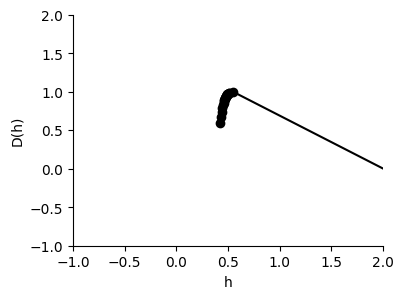

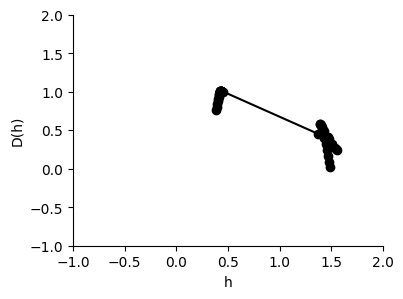

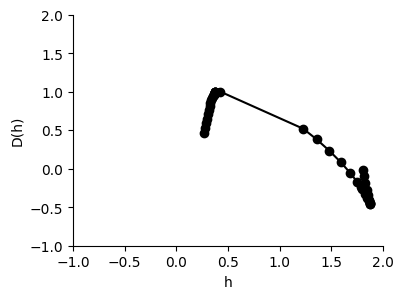

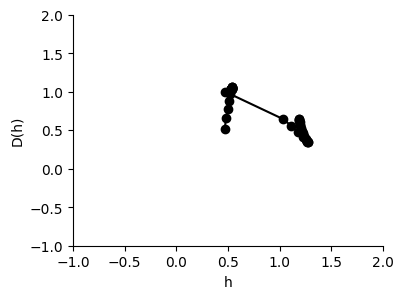

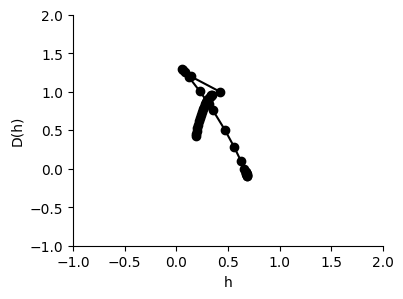

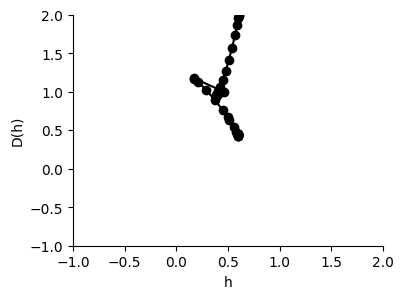

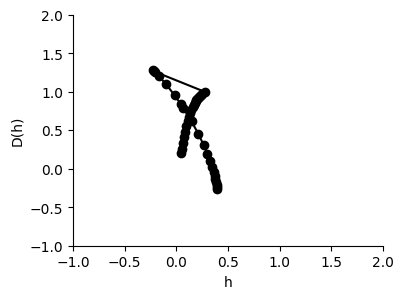

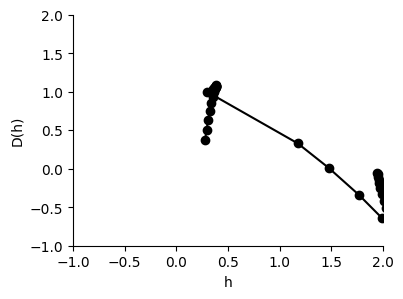

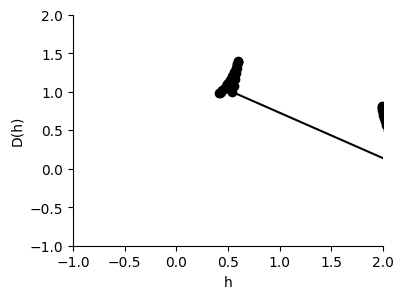

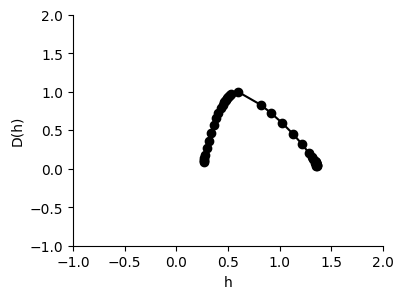

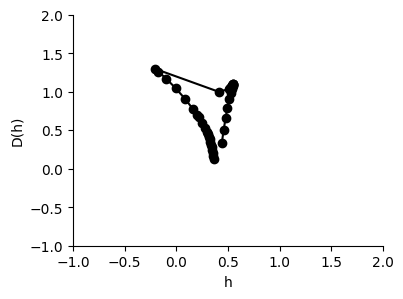

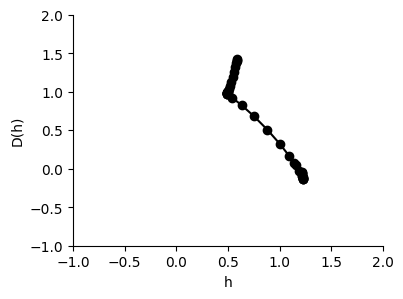

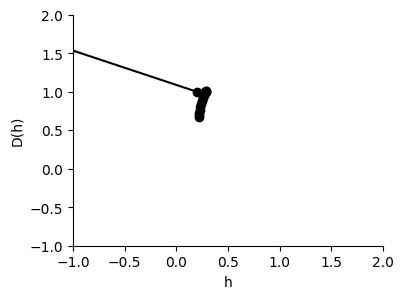

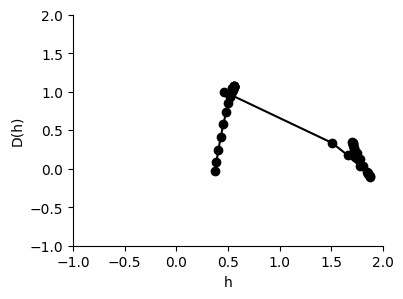

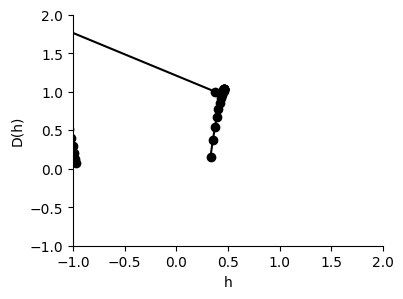

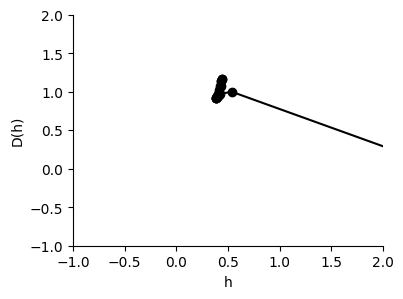

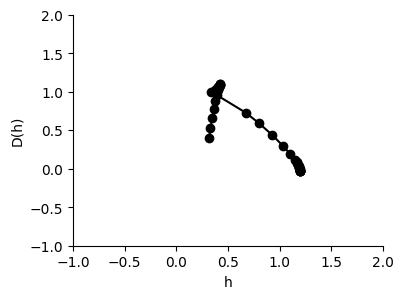

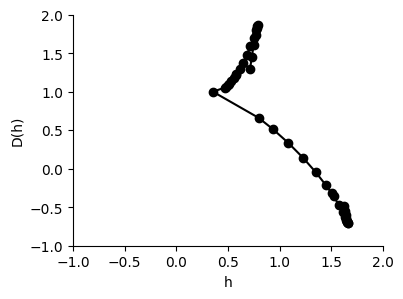

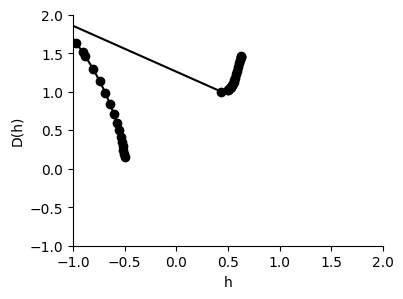

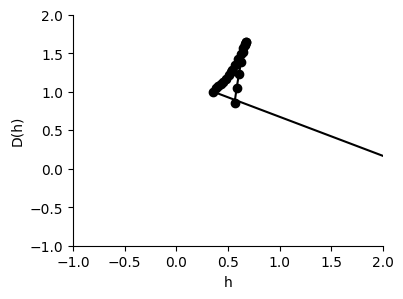

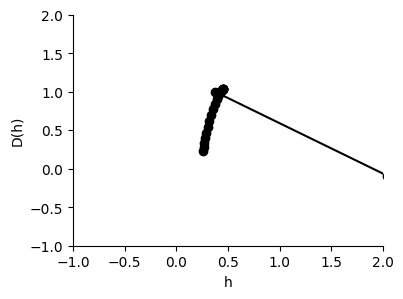

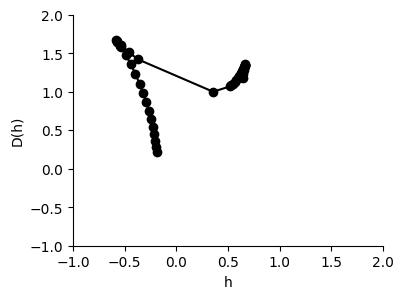

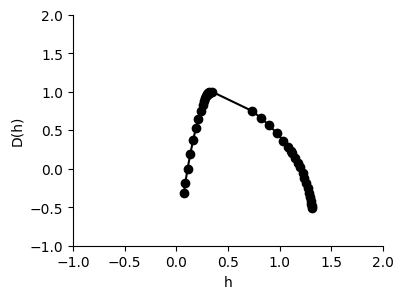

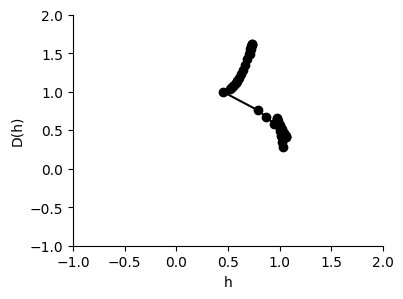

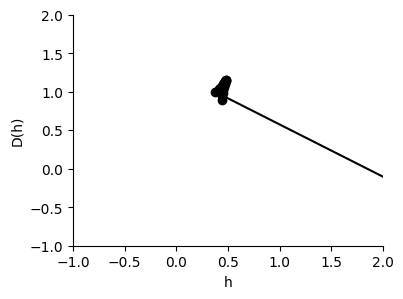

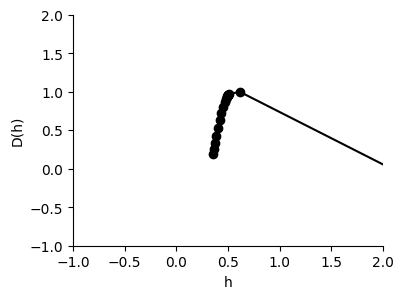

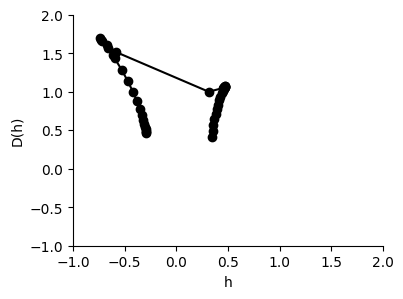

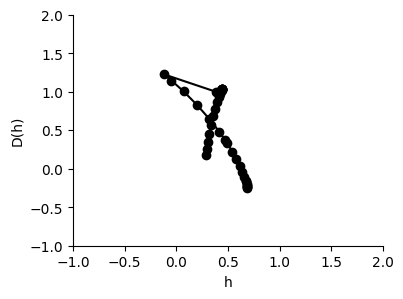

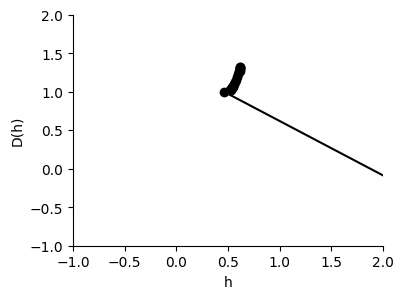

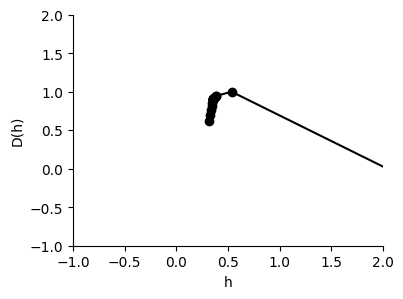

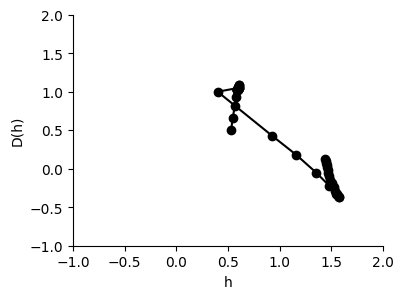

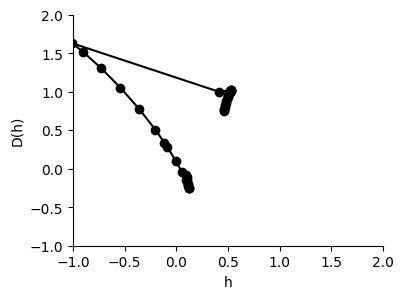

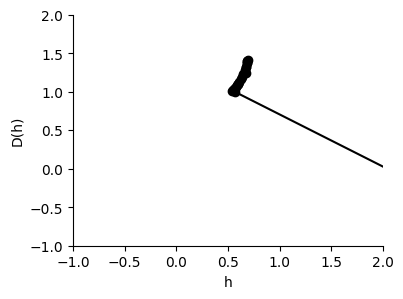

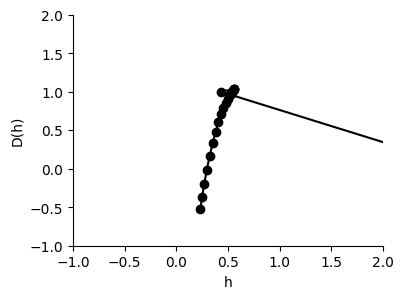

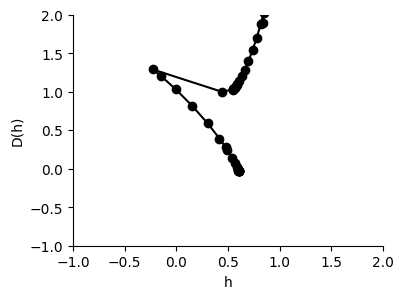

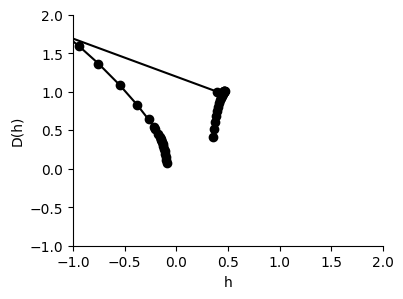

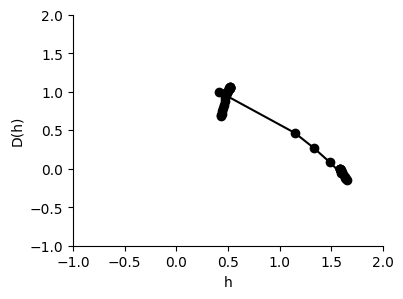

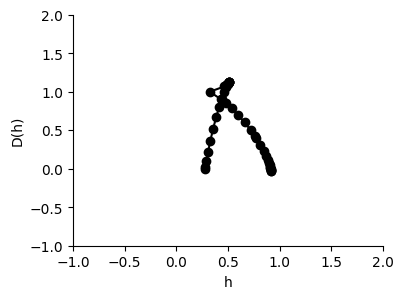

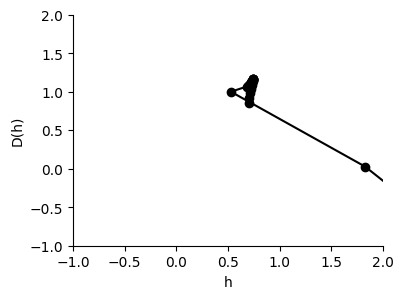

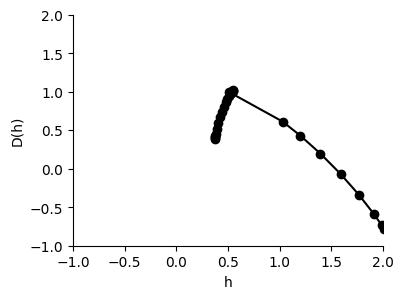

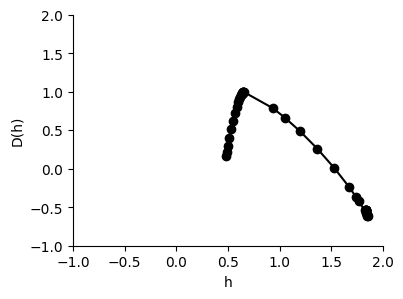

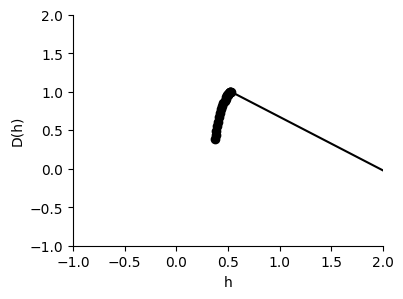

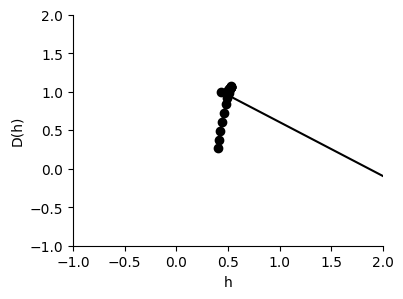

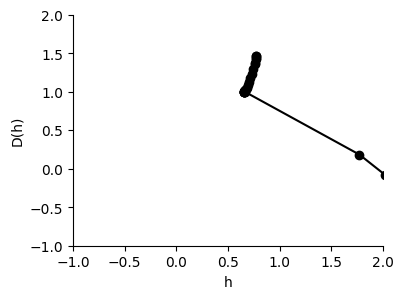

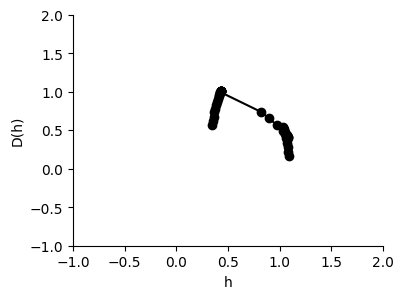

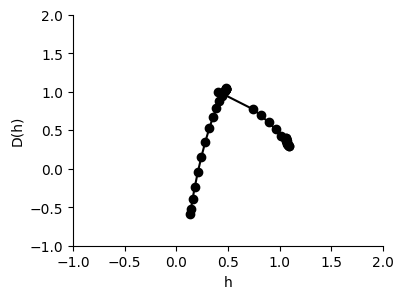

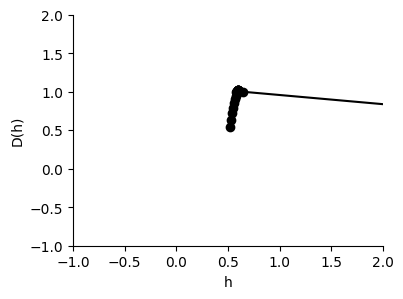

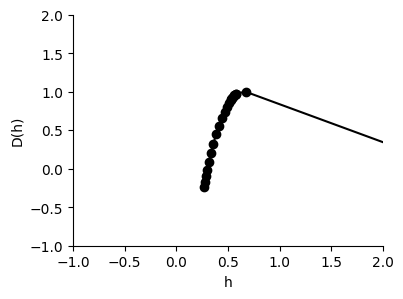

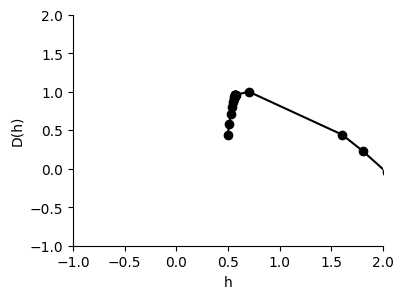

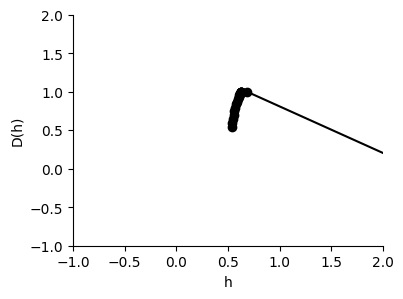

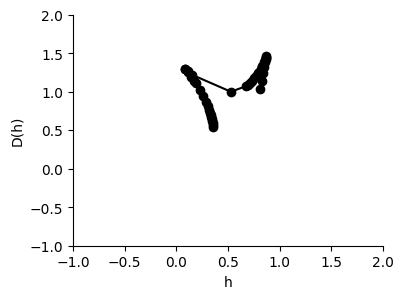

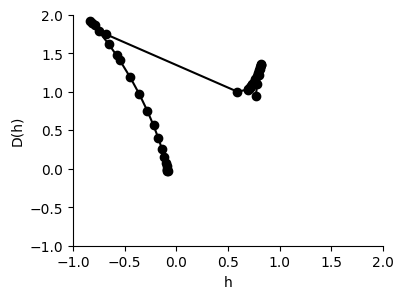

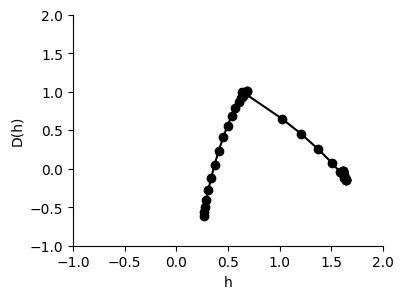

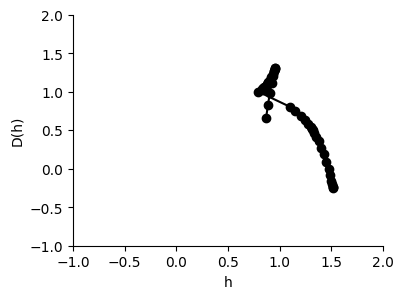

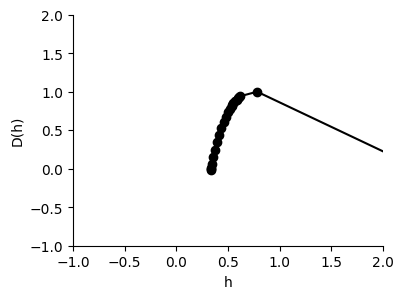

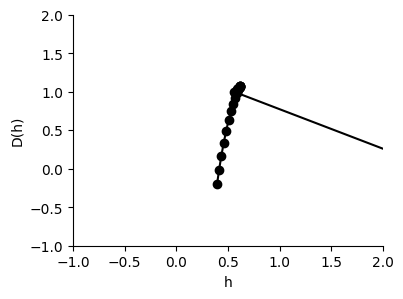

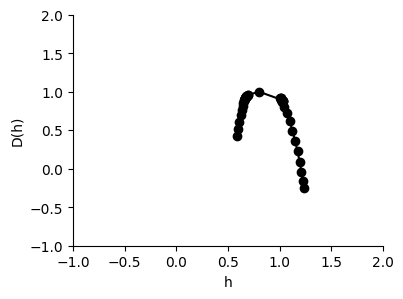

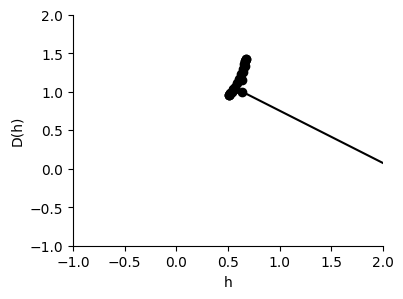

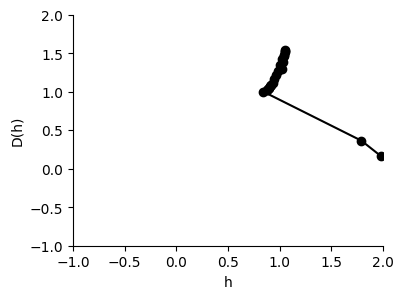

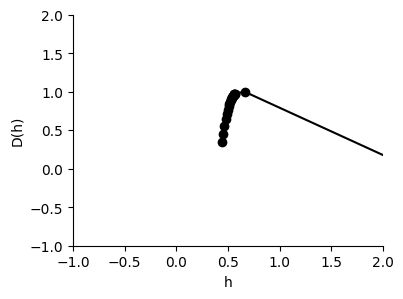

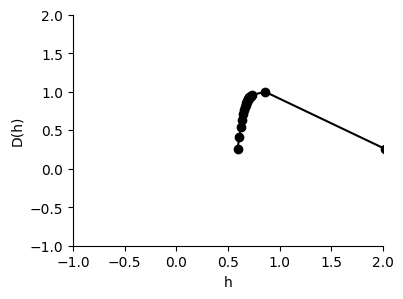

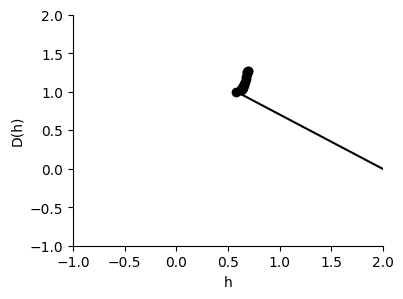

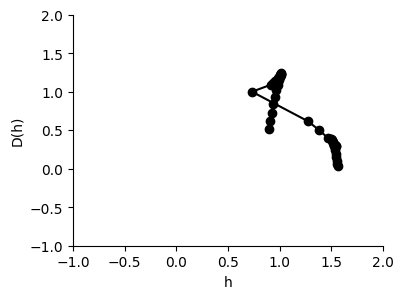

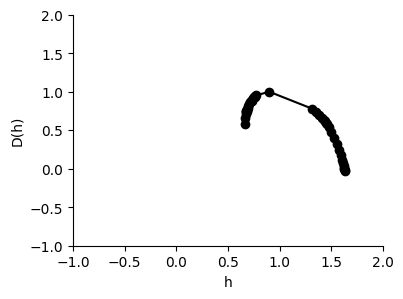

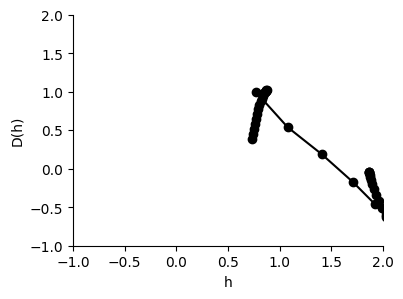

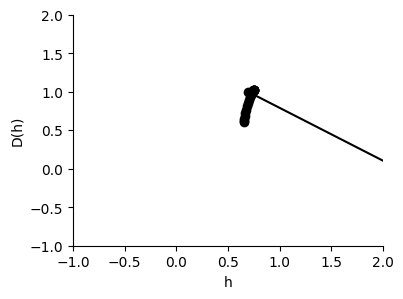

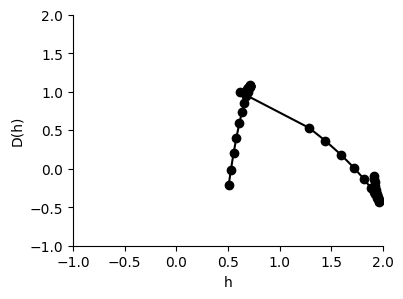

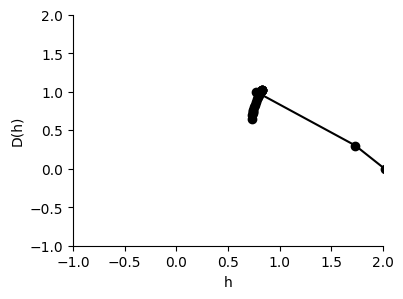

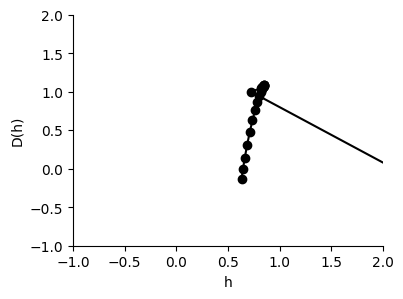

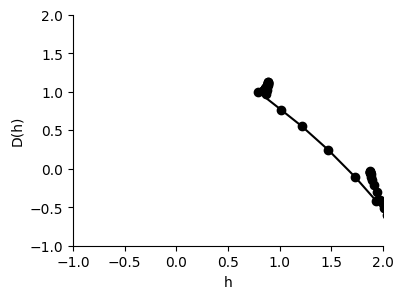

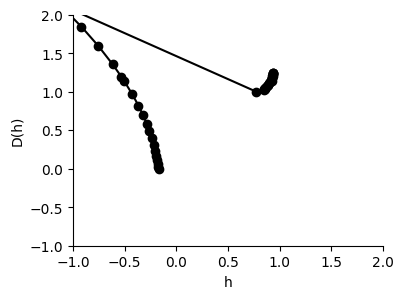

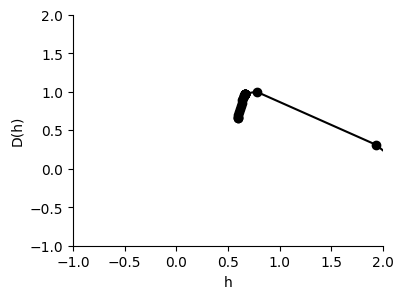

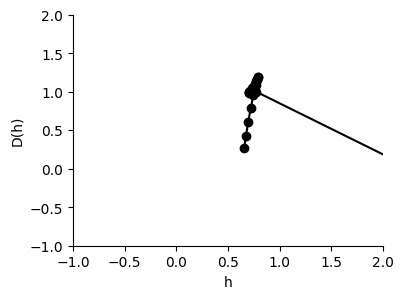

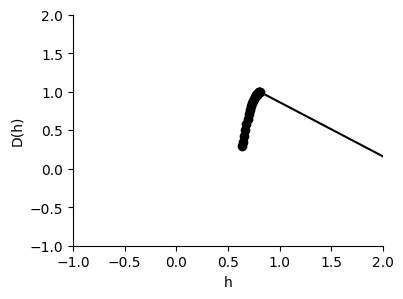

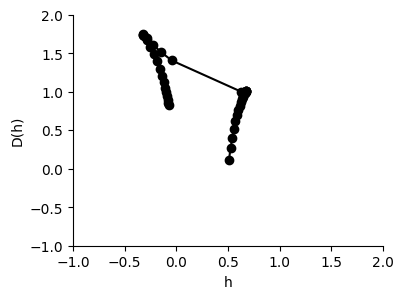

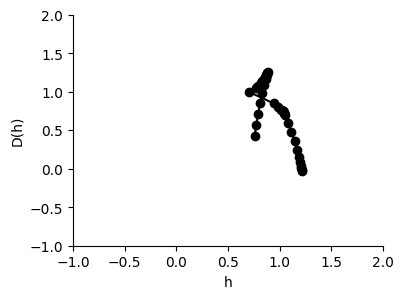

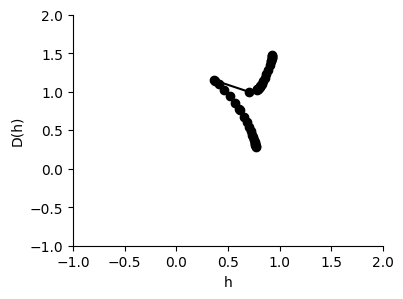

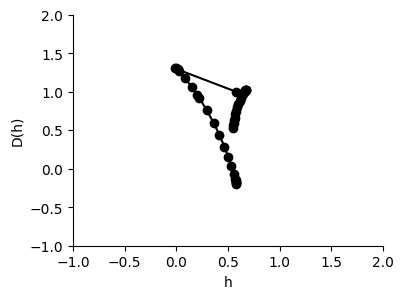

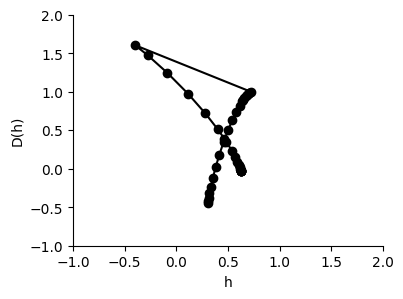

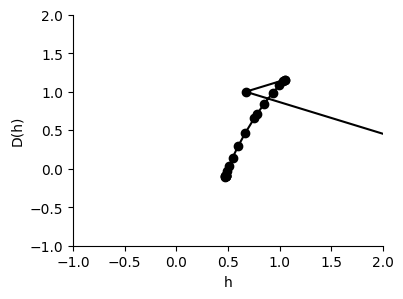

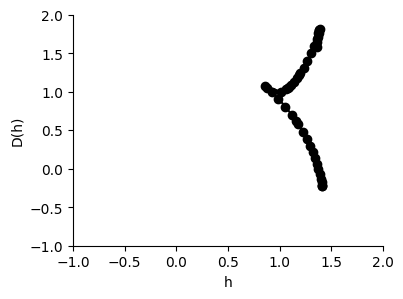

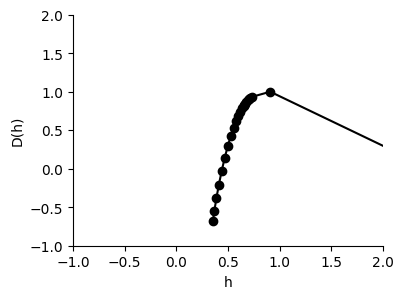

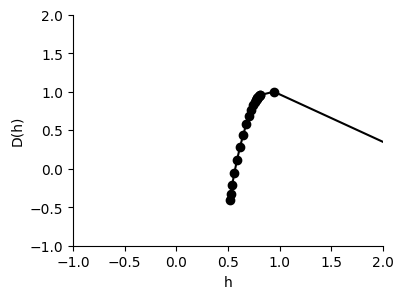

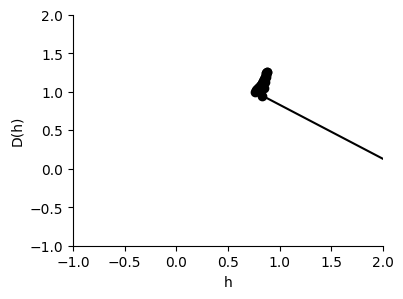

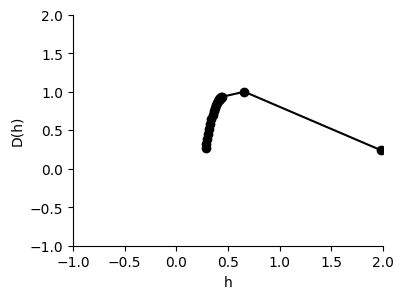

KeyboardInterrupt: 

In [114]:
def Dq_per_allParticipants():
    # user_id = [str(i) for i in range(20) if i not in (8, 18)] ['0','1','2',...]
    user_id = ['2']
    session_day = 'First' # 'Second'
    game_mode = ['o','m']
    # for mode in game_mode:
    for user in user_id:
        for mode in game_mode:
            participant_data_per_turn , participant_labels = dataset.load_session_by_participant(user, session_day,mode,"FP1")
            participant_data_per_turn,participant_labels  = dataset.flattern_turns(participant_data_per_turn,participant_labels)
            print(len(participant_data_per_turn))
            participant_labels = [item for sublist in participant_labels for item in sublist]
            # plt.plot(participant_data_per_turn, c='xkcd:darkblue')
            sns.despine()
            calc_Dq_window(participant_data_per_turn,600,False,False)
            # dwt_sf, dwt_cumul, dwt_mfs, hmin = mfda_features(np.array(participant_data_per_turn))

            # grouped_data_per_flevel= fatigue_vs_nofatiue_turn(participant_data_per_turn,participant_labels)
            # Dqs, q = calc_Dq(grouped_data_per_flevel)
            # plot_mean_Dq(Dqs, q, f"{user}_{session_day}_{mode}")

Dq_per_allParticipants()

In [ ]:
# def Dq_per_allParticipants():
#     user_id = [str(i) for i in range(20) if i != 18]
#     session_day = 'First'
#     game_mode = ['o','m']
#     # for mode in game_mode:
#     for user in user_id:
#         for mode in game_mode:
#             participant_data_per_turn , participant_labels = dataset.load_session_by_participant(user, session_day,mode,"FP1") ## each item in this data is eeg of one turn of the game, of channel FP1 at day one with V1 expriment
#             participant_labels = [item for sublist in participant_labels for item in sublist]
#             grouped_data_per_flevel= fatigue_vs_nofatiue_turn(participant_data_per_turn,participant_labels)
#             Dqs, q = calc_Dq(grouped_data_per_flevel)
#             plot_mean_Dq(Dqs, q, f"{user}_{session_day}_{mode}")

# Dq_per_allParticipants()